/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
✅ RMSE : 2.0170196853827402
✅ R² score : 0.2323514916956272


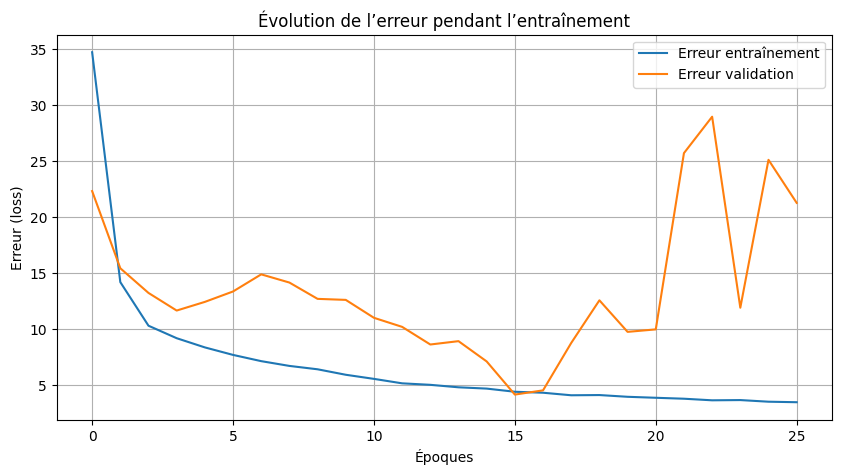

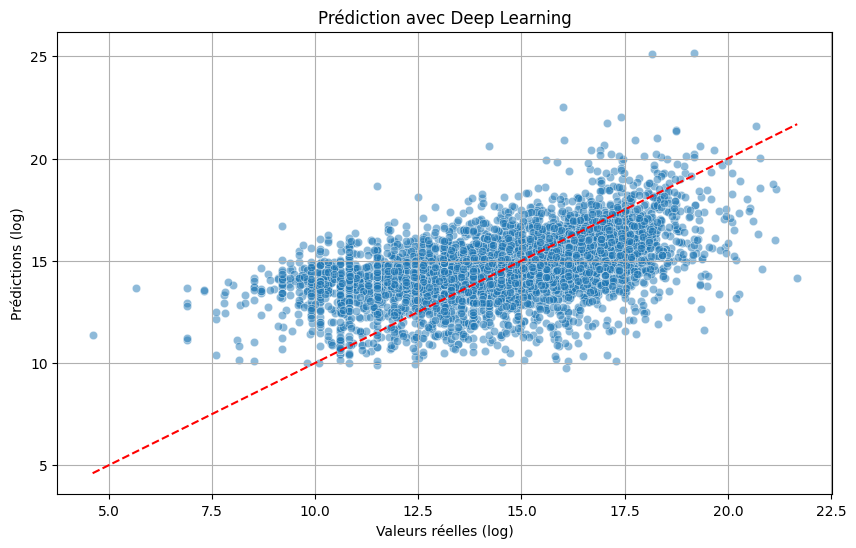

In [3]:
import pandas as pd # Manipulation de données tabulaires (exel,csv) sous forme de tableaux dataframes
import numpy as np  #calcul numérique rapides sur des tableaux (arrays)
import matplotlib.pyplot as plt #visualisation graphiques...
import seaborn as sns #faire des graphique s statistiques jolis et simple

from sklearn.model_selection import train_test_split #entrainer, tester et evaluer des modeles de ML
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf # construction et entrainement de réseaux de neurones profonds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Charge le dataset / constitution du dataframe / et suppression des espaces inutiles + passage en minuscule 
path = "/Users/amar/Desktop/Alyra_School/Alyra 2025/4- Projet/investments_VC.csv"

#------------
# NETTOYAGE ET PREPARATION DES DONNEES 
#------------

df = pd.read_csv(path, encoding='unicode_escape')
df.columns = df.columns.str.strip().str.lower()

# Colonnes utiles
cols = ['country_code', 'market', 'category_list', 'funding_rounds', 'founded_year', 'funding_total_usd']
df = df[cols]

# Nettoyage des montants
df['funding_total_usd'] = df['funding_total_usd'].replace(r'[\$,]', '', regex=True) # Suppression les caractères $ et , dans les montants
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')   # Conversion de la colonne en float. Les erreurs de conversion deviennent des NaN

# Nettoyage : suppression des NaN et des montants à 0
df.dropna(inplace=True)                 # Suppression de toutes les lignes contenant des valeurs manquantes sur ces colonnes (country_code, market, category_list, funding_rounds, founded_year, funding_total_usd)
df = df[df['funding_total_usd'] > 0]    #suprresion des lignes avec des montants de financement nuls ou négatifs.

# Transformation de la cible en log
df['log_funding'] = np.log1p(df['funding_total_usd'])   # on applique log1p (log(1+x) pour réduire les écarts de valeurs extremes

# Encodage des variables catégorielles  
# Drop(..): supprime les colonnes 'funding_total_usd' (montant réel--> version brut déjà transformée), 'log_funding' (cible de la prédiction--> variable cible (y))
# pd.get.dummies(..., drop first=True) : transforme les colonnes catégorielles(texte) en colonnes numériques grace à l'encodage one-hot.
#suppression de la première modalité de chaque colonne encodée pour éviter les redondance (multicolinéarité) 
X = pd.get_dummies(df.drop(['funding_total_usd', 'log_funding'], axis=1), drop_first=True)

# Cible
y = df['log_funding']   #variable cible de l'apprentissage

# Split train/test (scikit-learn)
# X_train : les features utilisées pour entraîner le modèle
# X_test : les features utilisées pour tester le modèle
# y_train : les valeurs cibles correspondantes à X_train
# y_test : les valeurs cibles correspondantes à X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation
scaler = StandardScaler()
# On crée un objet StandardScaler de sklearn.
# Cet outil permet de standardiser les données, c’est-à-dire de les transformer pour qu’elles aient :
# une moyenne (mean) de 0
# un écart-type (std) de 1
# -> Cela facilite l'entraînement car les variables ont des ordres de grandeur comparables.


X_train_scaled = scaler.fit_transform(X_train)
# Calculer la moyenne et l’écart-type des colonnes de X_train (c’est le .fit())
# Appliquer la transformation (c’est le .transform())
# Résultat : chaque colonne de X_train_scaled est centrée réduite.

X_test_scaled = scaler.transform(X_test)
# On applique la même transformation aux données de test X_test.
# on n’utilise pas .fit_transform() sur X_test, car on veut garder les mêmes paramètres (moyenne et écart-type) que ceux appris sur les données d'entraînement.

# Attention : 
# fit() = apprend les statistiques (moyenne, écart-type)
# transform() = applique la transformation (x - µ) / σ aux données

#-------------------
# Construction du modele de neurones en utilsant la bibliotheque Keras(Tensorflow)
#-------------------

# L’objectif est de prédire un montant (logarithmé), donc la sortie est une valeur continue.
# Le modele est composé de 3 couches de neurones Denses, entrecoupé de 2 couches de dropout (cachées) avec activation ReLU

# Il y a 2 couches  dense avec activation ReLU
# des couches Dropout pour éviter le surapprentissage (Overfifting)
# une sortie avec 1 seule valeur
# une compilation avec l'optimiseur Adam et une fonction de perte MSE (erreur quadratique moyenne)

# Création d’un modèle séquentiel, c’est-à-dire un empilement de couches linéaires les unes après les autres.
model = Sequential()

# Ajout 1ere couche Dense (fully connected) de 128 neurones avec activation ReLU(Rectified Linear Unit) pour introduire de la non linéarité
# La fonction ReLU transforme une valeur en elle-même si elle est positive, ou en 0 si elle est négative.
# Elle permet au réseau de mieux apprendre des fonctions complexes tout en restant très efficace à l'entraînement.

# input_dim=X_train_scaled.shape[1] : dimension d’entrée = nombre de features (colonnes) dans X_train_scaled.

# ReLU(x)={ x si x>0 (une droite) Sinon =0 si x≤0(une constante)

model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))

# Ajout d'une couche Dropout : pendant l'entrainement 30% des neurones sont désactivés aléatoirement pour éviter le surapprentissage(régularisation)
model.add(Dropout(0.3))

# Création de 2ieme couche Denses de 64 neurones + ReLU pour la non-linéarité
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))  # 1 seul neurone, pas de fonction d’activation 

# Configuration du modele avant entrainement pour apprendre en minimisant l’erreur quadratique moyenne, à l’aide de l’optimiseur Adam.

# Ce modele dit comment le modele va apprendre (l'optimiseur) et ce qu'il doit minimiser (fonction de perte)
# Adam : algo d'optimisation -> il ajuste le taux d'apprentissage a chaque itération (ajuste les poids pour réduire l'erreur : rapide, efficace, nécessite peu de réglages manuels)
    # Adam = Adaptive Moment Estimation : MAJ des poids du réseau (w) pendant l'apprentissage
        # Adam = Momentum + RMSProp
            # Momentum : il garde en mémoire une moyenne des anciennes directions comme une inertie
            # RMSProp : Root Mean Square Propagation - adapte automatiquement la taille des pas pour chaque poids.
                # Le pas = quantité de changement appliquée au poids du modele à chaque mise à jour. Détermine a quelle vitesse le modele apprend.
                # il dépend du gradient : direction à suivre pour réduire l'erreur
                # et du Learning rate : determine la taille du pas

# loss='mse -> Mean square error (erreur quadratique moyenne)= fonction de perte utilisé pour les prb de régression
    # --> calcul la moyenne des carrés de écarts entre les prédictions du modele et les vraies valeurs 
model.compile(optimizer='adam', loss='mse')

#-------------------
# Entrainement
#-------------------

# Entraînement en utilisant les données d'entrées X_train_scaled et les cibles y_train
# X_train_scaled : les données d’entrée (features), déjà normalisées. 
# y_train : les valeurs cibles qu’on veut prédire.
# epochs=100 : Le modèle va parcourir toutes les données d'entraînement 100 fois. Chaque passage complet sur l’ensemble s’appelle une "époque".
# batch_size=32: les données sont divisées en petits groupes de 32 exemples.
# Cela réserve automatiquement 20% des données d’entraînement pour valider le modèle à chaque époque.
# verbose=0 : Mode silence 
#l'objet history contient l'évolution des métrics à chaque époque. 
# history.history['loss'] : erreur d'entraînement
# history.history['val_loss'] : erreur de validation

# Dès que val_loss cesse de s'améliorer pendant 10 époques consécutives,
# le training s'arrête automatiquement, et les meilleurs poids sont restaurés.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop],verbose=0)

#-------------------
# Prédiction
#-------------------
# on lance la prédiction y_pred avec X_test_scaled valeur nouvelle
y_pred = model.predict(X_test_scaled)


#-------------------
# Évaluation
#-------------------

# On évalue l’erreur entre la vérité (y_test) et ce que le modèle a prédit (y_pred).
# mean_squared_error() = moyenne des carrés des écarts → mesure l’erreur moyenne.
#L'erreur moyenne est de 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# arrive à prédire 29,8% des fluctuations
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE : {rmse}")
print(f"✅ R² score : {r2}")

# 🔹 Visualisation

# Tracer la courbe de perte (training vs validation)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Erreur entraînement')
plt.plot(history.history['val_loss'], label='Erreur validation')
plt.xlabel('Époques')
plt.ylabel('Erreur (loss)')
plt.title('Évolution de l’erreur pendant l’entraînement')
plt.legend()
plt.grid(True)
plt.show()

#Avec 100 epoques 
# 🔵 Erreur entraînement (ligne bleue) :
# Elle diminue régulièrement et reste très basse.
# Le modèle apprend très bien les données d’entraînement.

# 🟠 Erreur validation (ligne orange) :
# Elle commence correctement (basse au départ), puis :
# Elle explose à partir d’environ 15-20 époques, avec de fortes variations (instabilité).
# Le modèle n’arrive plus à généraliser.
# Il est clairement en overfitting.
#>>> Ajout d'un early stop

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred.flatten(), alpha=0.5) # x-> valeur réelles et y-> valeurs prédites
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valeurs réelles (log)")
plt.ylabel("Prédictions (log)")
plt.title("Prédiction avec Deep Learning")
plt.grid(True)
plt.show()
